In [38]:
!pip install neuralprophet prophet==1.0 pystan==2.19.1.1  

You should consider upgrading via the '/Users/catdev/.pyenv/versions/3.8.16/bin/python3.8 -m pip install --upgrade pip' command.


In [13]:
import pandas as pd
from neuralprophet import NeuralProphet
from prophet import Prophet
from matplotlib import pyplot as plt
import pickle
import asyncio
from datetime import datetime, timedelta
import json


In [37]:
weatherData = pd.read_json('weatherData.json')
combined_array = []
combined_array.extend(weatherData.weather_records[0])
combined_array.extend(weatherData.weather_records[1])
combined_array.extend(weatherData.weather_records[2])
weatherData = pd.DataFrame(combined_array)
weatherData['createdAt'] = pd.to_datetime(weatherData['createdAt']).dt.tz_localize(None)
weatherData.head()

weatherDataForTraining = pd.read_csv('weather_records.csv')
weatherDataForTraining['createdAt'] = pd.to_datetime(weatherDataForTraining['createdAt']).dt.tz_localize(None)
weatherDataForTraining['weatherRecord'] = weatherDataForTraining['weatherRecord'].apply(lambda x: json.loads(x))
weatherDataForTraining['createdAt'] = weatherDataForTraining['createdAt'] + timedelta(days=39)

In [38]:
print(len(weatherData))

84311


In [39]:
weatherData.dtypes
# df['weatherRecord'].apply(lambda x: x['humidityFromDTH22'])

id                           int64
createdAt           datetime64[ns]
weatherRecord               object
WeatherStation              object
weatherStationId            object
dtype: object

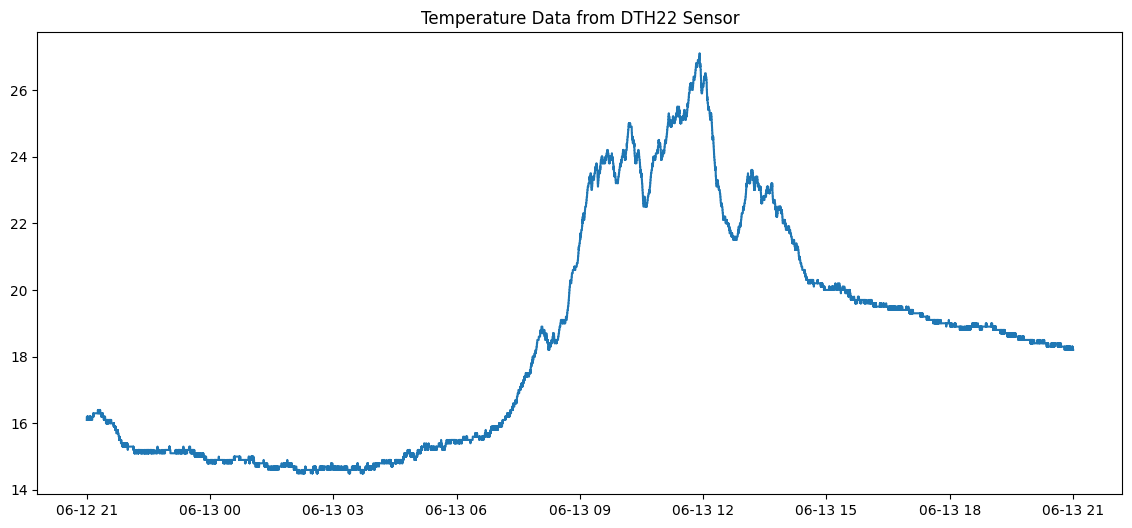

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(weatherDataForTraining['createdAt'], weatherDataForTraining['weatherRecord'].apply(lambda x: x['temperatureFromDTH22'] if x['temperatureFromDTH22'] <= 200000 else None))
plt.title("Temperature Data from DTH22 Sensor")
plt.show()

In [3]:
dataForTraining = pd.DataFrame({'ds': weatherDataForTraining['createdAt'], 'y': weatherDataForTraining['weatherRecord'].apply(lambda x: x['temperatureFromDTH22']) })
# data = pd.DataFrame({'ds': df['createdAt'], 'y': df['weatherRecord'].apply(lambda x: x['pressureFromBMP180'] if x['pressureFromBMP180'] <= 200000 else None)})
dataForTraining = dataForTraining.drop_duplicates()
dataForTraining = dataForTraining.dropna()

data = pd.DataFrame({'ds': weatherData['createdAt'], 'y': weatherData['weatherRecord'].apply(lambda x: x['temperatureFromDTH22']) })
# data = pd.DataFrame({'ds': df['createdAt'], 'y': df['weatherRecord'].apply(lambda x: x['pressureFromBMP180'] if x['pressureFromBMP180'] <= 200000 else None)})
data = data.drop_duplicates()
data = data.dropna()




# Train modal

In [42]:


m = NeuralProphet(
    # growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints_range=0.95,
    trend_reg_threshold=False,
    seasonality_mode="additive",
    epochs=10,
    #learning_rate=0.1,
    impute_missing=True
)


m.set_plotting_backend("matplotlib")  # Use matplotlib due to #1235
metrics = m.fit(dataForTraining, freq='10min', epochs=3)


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 2019L corresponds to 2.756% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq 10min. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
WAR

Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.25s/it, loss=0.00493, v_num=38, MAE=1.390, RMSE=1.830, Loss=0.00492, RegLoss=0.000]


In [43]:
future = m.make_future_dataframe(data, periods=300)
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency 1027L corresponds to 6.239% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq 10min. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 10T corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 10min
INFO - (NP.df_utils._infer_frequency) - Major frequency 10T corresponds to 99.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 10min


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.03it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly,season_daily
0,2023-06-13 21:10:12.534,None,77.723221,79.239021,0.473950,-1.989751
1,2023-06-13 21:20:12.534,None,77.644981,79.252441,0.474591,-2.082051
2,2023-06-13 21:30:12.534,None,77.566261,79.265869,0.475128,-2.174733
3,2023-06-13 21:40:12.534,None,77.487068,79.279297,0.475561,-2.267787
4,2023-06-13 21:50:12.534,None,77.407509,79.292717,0.475886,-2.361097


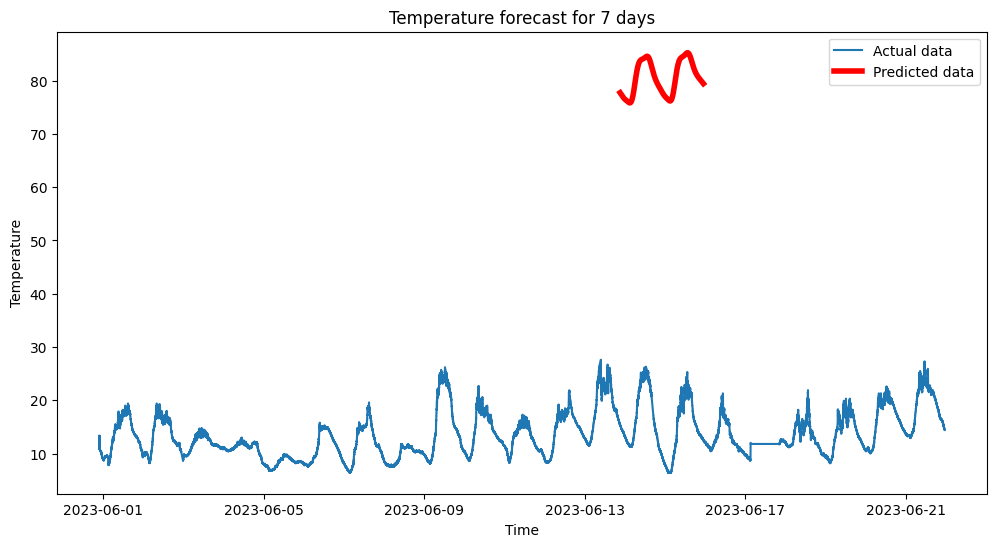

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual weather data
plt.plot(weatherDataForTraining['createdAt'], weatherDataForTraining['weatherRecord'].apply(lambda x: x['temperatureFromDTH22']), label='Actual data')

# Plot predicted data
ax.plot(forecast['ds'], forecast['yhat1'], label='Predicted data', linewidth=4, color='red')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature forecast for 7 days')

ax.legend()
plt.show()

# Train modal with Prophet

# Save modal

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(m,f)

# Open modal

In [ ]:
with open('model.pkl', 'rb') as f:
    m = pickle.load(f)
m.restore_trainer()

In [ ]:
future = m.make_future_dataframe(data, periods=1000)
# future['cap'] = 1024
# future['floor'] = 0
forecast = m.predict(future)
forecast.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data['ds'], data['y'], label='Actual data')

ax.plot(forecast['ds'], forecast['yhat1'], label='Predicted data')

ax.set_xlabel('Time')
ax.set_ylabel('Pressure')
ax.set_title('Data Frames Comparison')

ax.legend()
plt.show()